In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd
from torchvision.io import read_image
# for reading and displaying images
import matplotlib.pyplot as plt

# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score
import nibabel as nib
import glob
import random
import numpy as np
import os
from natsort import natsorted

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import h5py
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from aifnet_utils.preprocess import normalize_aif, normalize, normalize_zero_one

from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter
%matplotlib inline


In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Using {} device".format(device))

#Reading an example PCT volume
LOCATION = 'INSEL'

if LOCATION == 'HOME':
    ROOT_EXP = '/Users/admin/work/aifnet_replication-main'
    root_dir  = '/Users/admin/work/data/'


if LOCATION == 'LOCAL':
    ROOT_EXP = '/Users/sebastianotalora/work/postdoc/ctp/aifnet_replication/'
    root_dir  = '/Users/sebastianotalora/work/postdoc/data/ISLES/'

if LOCATION == 'INSEL':
    ROOT_EXP = '/home/sebastian/experiments/aifnet_replication/'
    root_dir  = '/media/sebastian/data/ASAP/ISLES2018_Training'

if LOCATION == 'SERVER':
    ROOT_EXP = '/home/sotalora/aifnet_replication/'
    root_dir     = '/data/images/sotalora/ISLES18/'

aif_annotations_path = ROOT_EXP + 'radiologist_annotations.csv'


aif_annotations_path = ROOT_EXP + '/radiologist_annotations_cleaned.csv'#'radiologist_annotations.csv'#'annotated_aif_vof_complete_revised.csv'
min_num_volumes_ctp = 43


Using cuda:0 device


In [3]:
class ISLESDataset(Dataset):
    def __init__(self, annotations_file, partition_file_path, 
                 minimum_number_volumes_ctp, img_dir, vascular_fn='AIF',
                 transform=None, target_transform=normalize_aif):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.minimum_number_volumes_ctp = minimum_number_volumes_ctp
        dataset_dir = os.path.join(img_dir, "TRAINING")
        dataset_dir_test = os.path.join(img_dir, "TESTING")
        self.filenames_4D = natsorted(glob.glob(dataset_dir + "/case_*/*4D*/*nii*") + glob.glob(dataset_dir_test + "/case_*/*4D*/*nii*"))
        self.cases_paths = {path.split('.')[-2]: path for path in self.filenames_4D}
        self.vascular_fn = vascular_fn
        partition_file = open(partition_file_path,'r')
        relevant_cases = []
        for line in partition_file:
            relevant_cases.append(line.split('.')[-2])
        partition_file.close()
        self.fold_img_paths = {key: self.cases_paths[key] for key in relevant_cases}
        self.fold_ids = [int(valid_indx) for valid_indx in list(self.fold_img_paths.keys())]
        self.all_labels = pd.read_csv(aif_annotations_path) 
        self.img_labels = self.all_labels[self.all_labels['imageID'].isin(self.fold_ids)]
        #print(self.fold_img_paths)
        
    def __len__(self):
        return len(self.fold_img_paths)

    def __getitem__(self, idx):
        img_id = str(self.img_labels.iloc[idx]['imageID'])
        img_path = self.fold_img_paths[img_id]
        image = read_volume_sequence(img_path,self.minimum_number_volumes_ctp)
        image = np.array(image,dtype=np.double)# CPU torch likes double type
        image = (image-image.mean())/image.max() #Normalizing the whole sequence
        AIF = image[self.img_labels.iloc[idx]['AIFx'],self.img_labels.iloc[idx]['AIFy'],self.img_labels.iloc[idx]['AIFz'],:]
        VOF = image[self.img_labels.iloc[idx]['VOFx'],self.img_labels.iloc[idx]['VOFy'],self.img_labels.iloc[idx]['VOFz'],:]
        label = AIF #By default return only the AIF
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        if self.vascular_fn == 'VOF':
            label = VOF
        #if use_cuda:
        #    return torch.tensor(image.T).cuda(), torch.tensor(label).cuda()
        #else:
        return torch.tensor(image.T), torch.tensor(label) #transpose since torch is happy when channels first
def read_volume_sequence(fname,minimum_number_volumes_ctp):
        cur_nib = nib.load(fname)
        ctp_vals = cur_nib.get_fdata()
        volume_sequence = ctp_vals[:,:,:,0:minimum_number_volumes_ctp]
        return volume_sequence

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.ToTensor()
    ]),
}

In [5]:
annotations_file = aif_annotations_path
current_fold = 1
minimum_number_volumes_ctp = 43
partition_file_training = ROOT_EXP + '/partitions_cleaned/fold_'+str(current_fold)+'/train_v2.txt'
partition_file_valid = ROOT_EXP + '/partitions_cleaned/fold_'+str(current_fold)+'/valid_v2.txt'
partition_file_test = ROOT_EXP + '/partitions_cleaned/fold_'+str(current_fold)+'/test_v2.txt'

training_data = ISLESDataset(
annotations_file, partition_file_training, 
                 minimum_number_volumes_ctp, root_dir, vascular_fn='AIF',
                 transform=None, target_transform=normalize_aif
)
valid_data = ISLESDataset(
annotations_file, partition_file_valid, 
                 minimum_number_volumes_ctp, root_dir, vascular_fn='AIF',
                 transform=None, target_transform=normalize_aif

)


In [6]:
sample_idx = torch.randint(10, size=(1,)).item()
img, label = training_data[sample_idx]


In [7]:
img.shape

torch.Size([43, 2, 256, 256])

In [8]:
print(np.array(label.cpu()).shape, img.shape)

(43,) torch.Size([43, 2, 256, 256])


Text(0, 0.5, 'Normalized Density (HU)')

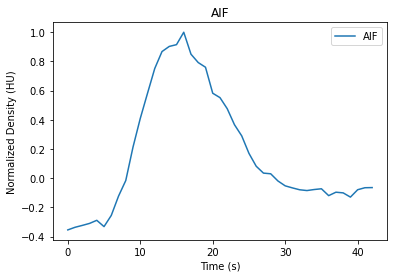

In [9]:
plt.title('AIF')        
#y = normalize_zero_one(aif)
#y_p = normalize_zero_one(vof)
#plt.plot(mu_voi)
#plt.plot(y_p)
plt.plot(normalize_aif(label.cpu().numpy()))
plt.legend([ 'AIF','VOF'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [10]:

train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)
#test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)


In [11]:
train_features, train_labels = next(iter(train_dataloader))
train_labels.shape


torch.Size([1, 43])

In [12]:
train_features.shape

torch.Size([1, 43, 8, 256, 256])

In [13]:
# Define model
class AIFNet(nn.Module):
    def __init__(self):
        super(AIFNet, self).__init__()
        
        self.firstConv3d  = self._conv3d_relu(in_c=43, out_c=16, k_size=(1,3,3),pad_size=(0,1,1))
        self.secondConv3d = self._conv3d_relu(in_c=16, out_c=32, k_size=(1,3,3),pad_size=(0,1,1))
        self.thirdConv3d  = self._conv3d_relu(in_c=32, out_c=64, k_size=(1,3,3),pad_size=(0,1,1))
        self.fourthConv3d = self._conv3d_relu(in_c=64, out_c=128, k_size=(1,3,3),pad_size=(0,1,1))
        self.Lout         = self._conv3d_relu(in_c=128, out_c=1, k_size=(1,3,3),pad_size=(0,1,1))
        self.softmax3d    = torch.nn.Softmax(dim=0)
        
    def _conv3d_relu(self, in_c, out_c, k_size,pad_size=0):
        conv_layer = nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=k_size,padding=pad_size,padding_mode='zeros'),
            nn.ReLU()
        )
        return conv_layer        
    def forward(self, input_x):
        x = torch.tensor(input_x)
        x = self.firstConv3d(input_x)
        x = self.secondConv3d(x)
        x = self.thirdConv3d(x)
        x = self.fourthConv3d(x)
        x = self.Lout(x)
        pvol_shape = x.shape
        Pvol = self.softmax3d(x.flatten())
        Pvol = Pvol.reshape(pvol_shape)
        voxelwise_mult = torch.mul(Pvol,input_x)
        #print(voxelwise_mult.sum())
        aif_hat = voxelwise_mult.mean(dim=(-3,-2,-1)) #This should be [N,TimePoints]
        return aif_hat

model = AIFNet().to(device)
print(model)


AIFNet(
  (firstConv3d): Sequential(
    (0): Conv3d(43, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (secondConv3d): Sequential(
    (0): Conv3d(16, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (thirdConv3d): Sequential(
    (0): Conv3d(32, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (fourthConv3d): Sequential(
    (0): Conv3d(64, 128, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (Lout): Sequential(
    (0): Conv3d(128, 1, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (softmax3d): Softmax(dim=0)
)


In [14]:
a = torch.tensor(np.array([[[1,2],[3,4]],[[5,5],[5,5]]]))
a = a[np.newaxis,:,:]
b = torch.tensor([[5,6],[7,8]])

torch.mul(a,b)

tensor([[[[ 5, 12],
          [21, 32]],

         [[25, 30],
          [35, 40]]]])

In [15]:
# With square kernels and equal stride
#m =nn.Conv3d(in_channels=43, out_channels=16, kernel_size=1)#43 volumes enter, 16 out, 1x1 kernels, stride=1 (First layer)
model.double()

# non-square kernels and unequal stride and with padding
#m = nn.Conv3d(16, 33, (3, 5, 2), stride=(2, 1, 1), padding=(4, 2, 0))

output = model(train_features.to(device))

<ipython-input-13-969ad2d69bef>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(input_x)


In [16]:
print(output.shape)
print(train_features.shape)
train_labels


torch.Size([1, 43])
torch.Size([1, 43, 8, 256, 256])


tensor([[-0.2668, -0.2205, -0.2284, -0.2188, -0.3015, -0.2213, -0.2893, -0.2888,
         -0.1608, -0.2532, -0.0779, -0.2118, -0.0252,  0.0784,  0.1954,  0.3441,
          0.4709,  0.8581,  0.7656,  1.0000,  0.9866,  0.8814,  0.8985,  0.9543,
          0.7785,  0.6958,  0.5570,  0.3216,  0.3274,  0.1492,  0.1682,  0.0248,
         -0.0468,  0.0109, -0.0891, -0.0630, -0.1519, -0.0666, -0.1139, -0.0303,
         -0.1871, -0.1353, -0.0459]], dtype=torch.float64)

In [17]:
output.sum()

tensor(1.1341e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)

In [18]:
def get_Pvol(input_sequence, model):
    return_layers = {'Lout': 'Lout'}
    mid_getter = MidGetter(model, return_layers=return_layers, keep_output=True)
    mid_outputs, model_output = mid_getter(input_sequence)
    Pvol = mid_outputs['Lout']
    pvol_shape = Pvol.shape
    Pvol = model.softmax3d(Pvol.flatten())
    Pvol = Pvol.reshape(pvol_shape)
    return Pvol

In [19]:
train_features.shape

torch.Size([1, 43, 8, 256, 256])

In [21]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        if X.shape[2] >4:
            continue
        print(X.shape)
        # Compute prediction and loss
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [22]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(torch.tensor(X[np.newaxis,:,:,:,:]).to(device))
            test_loss += loss_fn(pred, torch.tensor(y)).item()
            correct += (pred.argmax(1) == torch.tensor(y)).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [24]:
train_initial = True

learning_rate = 1e-3
batch_size = 1
epochs = 1
# Initialize the loss function
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
path_initial_model = ROOT_EXP + '/models_pytorch/initial_model.pth'


if train_initial:
    model.train()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        #test_loop(test_dataloader, model, loss_fn)
    print("Done!")
    #torch.save(model, path_initial_model)
else:
    # Model class must be defined somewhere
    model = torch.load(path_initial_model)
    model.eval()

Epoch 1
-------------------------------
torch.Size([1, 43, 2, 256, 256])


<ipython-input-13-969ad2d69bef>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(input_x)


torch.Size([1, 43, 4, 256, 256])
torch.Size([1, 43, 2, 256, 256])
torch.Size([1, 43, 4, 256, 256])
torch.Size([1, 43, 2, 256, 256])
loss: 0.195318  [   10/  107]
torch.Size([1, 43, 2, 256, 256])
torch.Size([1, 43, 4, 256, 256])
torch.Size([1, 43, 2, 256, 256])
torch.Size([1, 43, 2, 256, 256])
torch.Size([1, 43, 2, 256, 256])
torch.Size([1, 43, 2, 256, 256])
torch.Size([1, 43, 2, 256, 256])
torch.Size([1, 43, 2, 256, 256])
loss: 1.149835  [   20/  107]
torch.Size([1, 43, 4, 256, 256])
torch.Size([1, 43, 2, 256, 256])
torch.Size([1, 43, 2, 256, 256])
torch.Size([1, 43, 4, 256, 256])
torch.Size([1, 43, 2, 256, 256])
torch.Size([1, 43, 2, 256, 256])
torch.Size([1, 43, 2, 256, 256])
torch.Size([1, 43, 2, 256, 256])
loss: 1.296270  [   30/  107]
torch.Size([1, 43, 4, 256, 256])
torch.Size([1, 43, 4, 256, 256])
torch.Size([1, 43, 2, 256, 256])
torch.Size([1, 43, 2, 256, 256])
torch.Size([1, 43, 4, 256, 256])
torch.Size([1, 43, 2, 256, 256])
torch.Size([1, 43, 2, 256, 256])
torch.Size([1, 43, 

In [25]:
dataloader = valid_data
size = len(dataloader)
num_batches = len(dataloader)
test_loss, correct = 0, 0
preds_gt = []
with torch.no_grad():
    for X, y in dataloader:
        pred = model(torch.tensor(X[np.newaxis,:,:,:,:]).to(device))
        test_loss += loss_fn(pred.to('cpu'), torch.tensor(y).to('cpu')).item()
        correct += (pred.to('cpu').argmax(1) == torch.tensor(y).to('cpu')).type(torch.float).sum().item()
        preds_gt.append([pred.to('cpu').numpy(), torch.tensor(y).to('cpu').numpy()])
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


<ipython-input-25-b05169e7eed3>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model(torch.tensor(X[np.newaxis,:,:,:,:]).to(device))
<ipython-input-13-969ad2d69bef>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(input_x)
<ipython-input-25-b05169e7eed3>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_loss += loss_fn(pred.to('cpu'), torch.tensor(y).to('cpu')).item()
/home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.864501 



In [26]:
preds_gt = np.array(preds_gt)
preds_gt.shape

<ipython-input-26-790b624c3d4a>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  preds_gt = np.array(preds_gt)


(13, 2)

Text(0, 0.5, 'Normalized Density (HU)')

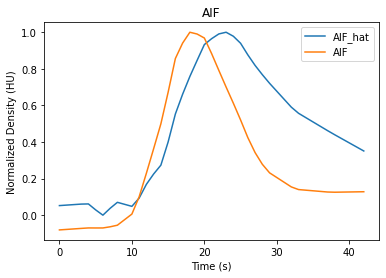

In [74]:
sample_idx = 10

plt.title('AIF')        
#y = normalize_zero_one(aif)
#y_p = normalize_zero_one(vof)
#plt.plot(mu_voi)
#plt.plot(y_p)

plt.plot(normalize_zero_one(preds_gt[sample_idx][0][0]))
plt.plot(preds_gt[sample_idx][1])

plt.legend([ 'AIF_hat','AIF'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [133]:
pvol = get_Pvol(torch.tensor(X[np.newaxis,:,:,:,:]).to(device), model)
pvol = pvol.to('cpu').detach().numpy()


<ipython-input-133-ea4353bacffc>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pvol = get_Pvol(torch.tensor(X[np.newaxis,:,:,:,:]).to(device), model)
<ipython-input-105-969ad2d69bef>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(input_x)


RuntimeError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 7.93 GiB total capacity; 4.63 GiB already allocated; 544.19 MiB free; 5.61 GiB reserved in total by PyTorch)

In [72]:
pvol = pvol[0,0,:,:,:].T

In [73]:
pvol.shape

(256, 256, 16)

In [74]:
from aifnet_utils.deconv import save_nifti_from_array_and_referenceHeader

In [75]:
dataloader.fold_img_paths

{'346172': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_90/SMIR.Brain.XX.O.CT_4DPWI.346172/SMIR.Brain.XX.O.CT_4DPWI.346172.nii',
 '345808': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_38/SMIR.Brain.XX.O.CT_4DPWI.345808/SMIR.Brain.XX.O.CT_4DPWI.345808.nii',
 '346137': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_85/SMIR.Brain.XX.O.CT_4DPWI.346137/SMIR.Brain.XX.O.CT_4DPWI.346137.nii',
 '345561': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_1/SMIR.Brain.XX.O.CT_4DPWI.345561/SMIR.Brain.XX.O.CT_4DPWI.345561.nii',
 '345568': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_2/SMIR.Brain.XX.O.CT_4DPWI.345568/SMIR.Brain.XX.O.CT_4DPWI.345568.nii',
 '345990': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_64/SMIR.Brain.XX.O.CT_4DPWI.345990/SMIR.Brain.XX.O.CT_4DPWI.345990.nii',
 '345997': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_65/SMIR.Brain.XX.O.CT_4DPWI.345997/SMIR.Brain.XX.O.CT_4DPWI.

In [76]:
dataloader.img_labels

,imageID,AIFx,AIFy,AIFz,VOFx,VOFy,VOFz
0,346290,82,141,0,138,58,1
1,346299,126,170,0,138,41,0
25,346605,87,129,0,138,49,0
33,346661,140,181,0,121,28,1
34,346668,79,115,0,121,26,0
57,345561,143,139,0,128,50,0
58,345568,122,147,0,125,30,0
94,345808,171,122,0,137,10,1
120,345990,114,163,0,152,22,1
121,345997,126,147,0,146,15,1


In [77]:
save_nifti_from_array_and_referenceHeader(pvol,'/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_94/SMIR.Brain.XX.O.CT_4DPWI.346200/SMIR.Brain.XX.O.CT_4DPWI.346200.nii','test_pvol.nii')

In [51]:
save_nifti_from_array_and_referenceHeader??

In [53]:
!pwd

/home/sebastian/experiments/aifnet_replication
